Standard imports. ```import cv2``` imports OpenCV for python.

In [0]:
import numpy as np
import math

import cv2
import matplotlib.pyplot as plt

Parameters.

In [0]:
numIters = 30                   # --- Number of iterations

lamb        = 6.328e-07         # --- Wavelength        
ps          = 1e-6              # --- Pixel size
dz          = 2e-5              # --- Distance between two consecutive planes

Propagate function.

In [0]:
def propagate(Ein, lamb, dz, ps):

   Nrows, Ncols = Ein.shape

   X, Y = np.meshgrid(range(-np.int32(Ncols / 2), Ncols - np.int32(Ncols / 2)), range(-np.int32(Nrows / 2), Nrows - np.int32(Nrows / 2)))

   fx     = X / (ps * Nrows)     # --- Angular spatial frequency along X [1 / m]
   fy     = Y / (ps * Ncols);    # --- Angular spatial frequency along Y [1 / m]
   fx2fy2 = np.power(fx, 2) + np.power(fy, 2)

   E0fft  = np.fft.fftshift(np.fft.fft2(Ein))

   Eout   = np.fft.ifft2(np.fft.ifftshift(E0fft * np.exp(-1j * np.pi * lamb * dz * fx2fy2)))

   return Eout

Gerchberg-Saxton algorithm: propagates guessed phase to a single plane upon each iteration.

In [0]:
def gerchbergSaxton(I1, I2, I3, dz, ps, lamb, numIters):

   # --- I1        : image intensity at left plane
   # --- I2        : image intensity at center plane
   # --- I3        : image intensity at right plane
   # --- dz        : distance between I2 and I3 and between I1 and I2; note that dz is positive when propagating from I2 to I3 and negative when propagating from I2 to I1.
   # --- ps        : pixel size
   # --- lamb      : wavelength
   # --- numIters  : number of iterations
   # --- phi       : image phase at center plane recovered by the algorithm

   Nrows, Ncols = I2.shape

   # --- Initial guess. The phase on the central plane is chosen as vanishing
   I2estimated = np.sqrt(I2) * np.exp(1j * np.random.randn(Nrows, Ncols))

   for iter in range(numIters):
    
     # --- Propagate from I2 to I3 and replace intensity with measurement
     I3estimated = propagate(I2estimated, lamb, dz, ps)
     I3estimated = np.sqrt(I3) * np.exp(1j * np.angle(I3estimated))
    
     # --- Propagate from I3 to I2 and replace intensity with measurement
     I2estimated = propagate(I3estimated, lamb, -dz, ps);
     I2estimated = np.sqrt(I2) * np.exp(1j * np.angle(I2estimated))
    
     # --- Propagate from I2 to I1 and replace intensity with measurement
     I1estimated = propagate(I2estimated, lamb, -dz, ps);
     I1estimated = np.sqrt(I1) * np.exp(1j * np.angle(I1estimated))
    
     # --- Propagate from I1 to I2 and replace intensity with measurement
     I2estimated = propagate(I1estimated, lamb, dz, ps)
     I2estimated = np.sqrt(I2) * np.exp(1j * np.angle(I2estimated))

   phi = I2estimated

   return phi

Loading the image. ```.astype(float)``` copies the array and casts it to ```float```. ```np.asarray``` converts a list to an array.

Text(0.5, 1.0, 'Input image')

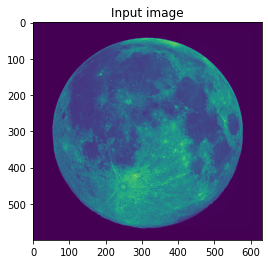

In [5]:
# --- https://commons.wikimedia.org/wiki/File:FullMoon2010.jpg

filename    = 'moonFree.jpg'
test1       = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
test1       = test1.astype(float)
test1       = np.asarray(test1, float)

plt.figure(1)
plt.imshow(test1)
plt.title('Input image')


Text(0.5, 1.0, 'Result')

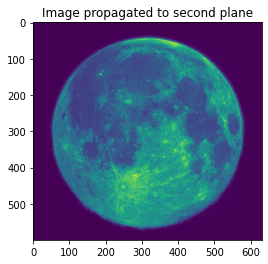

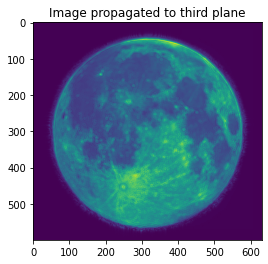

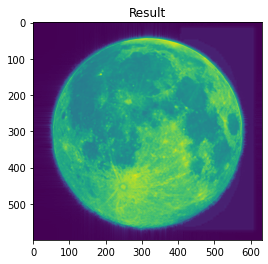

In [6]:
test2 = propagate(test1, lamb,     dz, ps)
test3 = propagate(test1, lamb, 2 * dz, ps)

plt.figure(2)
plt.imshow(np.abs(test2))
plt.title('Image propagated to second plane')

plt.figure(3)
plt.imshow(np.abs(test3))
plt.title('Image propagated to third plane')

phi = gerchbergSaxton(test1, test2, test3, dz, ps, lamb, numIters)

plt.figure(4)
plt.imshow(np.abs(phi))
plt.title('Result')